# TFG: Interpretabilidad en los modelos de ML

        Alumna: Yinbei Li                          Tutora: Elisenda Molina Ferragut

# Librerías y funciones

Importamos unas librerías básicas y algunas funciones auxiliares que usaremos durante el trabajo.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px

import f_auxiliares as f_aux

# Introducción y objetivos

Para ver cómo aplicar los métodos de interpretabilidad basados en el valor de Shapley, utilizaremos un conjunto de datos de Kaggle: https://www.kaggle.com/datasets/rishikeshkonapure/home-loan-approval con el objetivo de clasificar si se aprueba un préstamo hipotecario teniendo en cuenta una serie de características. Posteriormente, aplicaremos métodos de interpretabilidad basados en el valor de Shapley para explicar los resultados obtenidos.

En este conjunto de datos, los individuos de estudio son los préstamos. Está compuesto por 614 observaciones con información agrupada en 13 características o variables, que se detallan a continuación:


| Nombre | Tipo |Descripción|
|:-------------------|:---|:---|
| **Loan_ID** | cualitativa |ID del préstamo | 
| **Gender** |cualitativa | género del prestatario (hombre / mujer) | 
| **Married** |cualitativa |estado civil del prestatario (casado / no casado) | 
| **Dependents** |cualitativa ordinal | número de dependientes (0/1/2/3+)| 
| **Education** |cualitativa |nivel educativo del prestatario (no graduado / graduado)| 
| **Self_Employed** |cualitativa|indica si el prestatario es autónomo o no (sí / no)|
| **ApplicantIncome** |cuantitativa continua|ingreso del solicitante | 
| **CoapplicantIncome** | cuantitativa continua|ingreso del cosolicitante| 
| **LoanAmount** |cuantitativa continua|monto del préstamo (en miles de unidades monetarias) | 
| **Loan_Amount_Term** | cuantitativa discreta|plazo del préstamo en meses| 
| **Credit_History** |cualitativa |indica si el historial crediticio del prestatario cumple con las pautas (1 / 0)| 
| **Property_Area** |cualitativa|zona de propiedad (urbana / semiurbana / rural)| 
| **Loan_Status** |cualitativa|estado de aprobación del préstamo (sí / no)| 



In [2]:
df = pd.read_csv('loan_sanction_train.csv')

In [3]:
df.shape

(614, 13)

In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Preprocessing y visualización de los datos


## Tipos de variables

Veamos los tipos de variables:

In [5]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None


Observamos que tenemos 7 variables de tipo object, es decir, cualitativas; y 5 variables numéricas (float e int). A continuación, podemos ver en la siguiente tabla unas estadísticas descriptivas básicas (media, desviación típica, mínimo, máximo y cuartiles) para las variables numéricas. 

In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


## Valores duplicados

Antes de seguir, es necesario realizar un estudio de los valores duplicados y valores missing.

In [7]:
print('Número de valores duplicados:', df.shape[0] - df.drop_duplicates().shape[0])

Número de valores duplicados: 0


## Valores missings

Vemos que no tiene ningún valor duplicado, pero sí presentan algunos valores perdidos en ciertas características. 

In [8]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [9]:
(df.isna().sum() / df.shape[0] ) * 100 

Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

En general, no presenta un gran número de valores perdidos. El mayor porcentaje de valor missing se encuentra en la variable *Credit_History* con un 8.14%. A continuación, analizaremos variable por variable para tratar estos valores missings, se harán modificaciones adecuadas en cada uno de ellos. Además, se mostrarán algunas algunas gráficas para ayudar a comprender mejor estos datos.

### Loan_ID

Vamos a eliminar la columna *Loan_ID*, ya que solo se trata de un identificador del préstamo y no aporta información relevante para la aprobación de la hipoteca.

In [10]:
df.drop(['Loan_ID'], axis=1, inplace= True)

### Gender 

In [11]:
df['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [12]:
df[df['Gender'].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
23,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
126,NaN,Yes,3+,Graduate,No,23803,0.0,370.0,360.0,1.0,Rural,Y
171,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
188,NaN,Yes,0,Graduate,Yes,674,5296.0,168.0,360.0,1.0,Rural,Y
314,NaN,Yes,0,Graduate,No,2473,1843.0,159.0,360.0,1.0,Rural,N
334,NaN,Yes,1,Graduate,Yes,9833,1833.0,182.0,180.0,1.0,Urban,Y
460,NaN,Yes,0,Graduate,Yes,2083,4083.0,160.0,360.0,NaN,Semiurban,Y
467,NaN,Yes,0,Graduate,No,16692,0.0,110.0,360.0,1.0,Semiurban,Y
477,NaN,Yes,2,Graduate,No,2873,1872.0,132.0,360.0,0.0,Semiurban,N
507,NaN,No,0,Graduate,No,3583,0.0,96.0,360.0,1.0,Urban,N


Observamos que la mayoría de las observaciones con valores faltantes en *Gender* están casadas y graduadas, y no es posible determinar el género de estos valores missings utilizando el resto de características. Dado que solo el 2.11% de valores de *Gender* son missings, eliminaremos directamente estos casos.

In [13]:
df = df.dropna(subset=['Gender'])

<AxesSubplot:ylabel='Gender'>

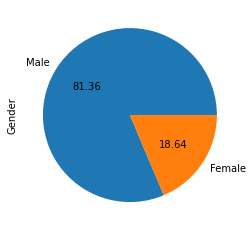

In [14]:
df['Gender'].value_counts().plot(kind='pie',autopct='%.2f')

De las 601 observaciones (489 hombres y 112 mujeres), se observa un 81.36% corresponden a hombres, mientras que el 18.64% corresponden a mujeres.

### Married  

In [15]:
df['Married'].value_counts()

Yes    388
No     210
Name: Married, dtype: int64

In [16]:
df[df['Married'].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


Para la característica *Married* se seguirá un procedimiento similar. Además, las observaciones con valores nulos en *Married* también tienen valores nulos en *Dependents*, por lo que al eliminarlos, también se corregirán los missing de *dependents*.

In [17]:
df = df.dropna(subset=['Married'])

### Dependents  

In [18]:
df['Dependents'].value_counts()

0     338
1     101
2      99
3+     48
Name: Dependents, dtype: int64

In [19]:
df[df['Dependents'].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,Male,Yes,NaN,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
120,Male,Yes,NaN,Graduate,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
226,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
293,Female,No,NaN,Graduate,No,5417,0.0,143.0,480.0,0.0,Urban,N
301,Male,Yes,NaN,Not Graduate,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
332,Male,No,NaN,Graduate,No,2833,0.0,71.0,360.0,1.0,Urban,Y
335,Male,Yes,NaN,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
346,Male,Yes,NaN,Not Graduate,No,3523,3230.0,152.0,360.0,0.0,Rural,N
355,Female,No,NaN,Graduate,No,3813,0.0,116.0,180.0,1.0,Urban,Y
517,Male,Yes,NaN,Not Graduate,No,3074,1800.0,123.0,360.0,0.0,Semiurban,N


In [20]:
pd.crosstab(df['Married'], df['Dependents'])

Dependents,0,1,2,3+
Married,,,,
No,169,23,8,6
Yes,169,78,91,42


De todas las observaciones en las que *Dependents* tiene valores missing, se observa que 8 de las 12 corresponden a prestatarios casados. En la tabla anterior, se observa que la mayoría de los prestatarios, independientemente de su estado civel, tienen 0 dependientes en la variable *Dependents*. Por lo tanto, vamos a reemplazar los valores missing por 0, considerando que el individuo no tienen ningún dependiente. 

Además para poder convertir la variable *Dependents* a una variable numérica, vamos a reemplazar la categoría *3+* por *3*. De esta forma, si el número de dependientes de algún individuo es igual a *3*, significa que tiene 3 o más dependientes.

In [21]:
df['Dependents'] = df['Dependents'].fillna('0')

In [22]:
df["Dependents"] = df["Dependents"].replace('3+',3)
df['Dependents'] = pd.to_numeric(df['Dependents'])

In [23]:
df['Dependents'].value_counts()

0    350
1    101
2     99
3     48
Name: Dependents, dtype: int64

<AxesSubplot:xlabel='Dependents', ylabel='count'>

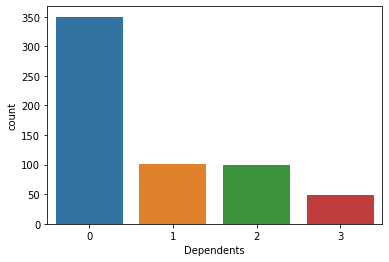

In [24]:
sns.countplot(df['Dependents'])

### Education  

La variable *Education* no tiene ningún valor missing, por lo tanto, no es necesario realizar ninguna modificación en ella.

In [25]:
df['Education'].value_counts()

Graduate        465
Not Graduate    133
Name: Education, dtype: int64

### Self_Employed  

In [26]:
df['Self_Employed'].value_counts()

No     488
Yes     78
Name: Self_Employed, dtype: int64

In [27]:
df[df['Self_Employed'].isnull()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
11,Male,Yes,2,Graduate,NaN,2500,1840.0,109.0,360.0,1.0,Urban,Y
19,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,Y
24,Male,Yes,1,Graduate,NaN,3717,2925.0,151.0,360.0,NaN,Semiurban,N
29,Female,No,2,Graduate,NaN,3750,2083.0,120.0,360.0,1.0,Semiurban,Y
30,Male,Yes,1,Graduate,NaN,4166,3369.0,201.0,360.0,NaN,Urban,N
95,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
107,Male,No,0,Not Graduate,NaN,7333,0.0,120.0,360.0,1.0,Rural,N
111,Female,Yes,0,Graduate,NaN,2929,2333.0,139.0,360.0,1.0,Semiurban,Y
114,Male,No,0,Graduate,NaN,5050,0.0,118.0,360.0,1.0,Semiurban,Y
158,Male,No,0,Graduate,NaN,2980,2083.0,120.0,360.0,1.0,Rural,Y


In [28]:
pd.crosstab(df['Education'], df['Self_Employed'])

Self_Employed,No,Yes
Education,,
Graduate,378,61
Not Graduate,110,17


Al igual que en casos anteriores, al observar las observaciones donde la variable *Self_Employed* es missing, seguimos sin tener información suficiente para decidir si el solicitante es autónomo o no. 

Dado que la mayoría de los solicitantes no son autónomos, asumiremos que aquellos con valores missing tampoco lo son.

In [29]:
df['Self_Employed'] = df['Self_Employed'].fillna('No')

In [30]:
df['Self_Employed'].value_counts()

No     520
Yes     78
Name: Self_Employed, dtype: int64

### ApplicantIncome  

La variable *ApplicantIncome* no tiene ningún valor missing.

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

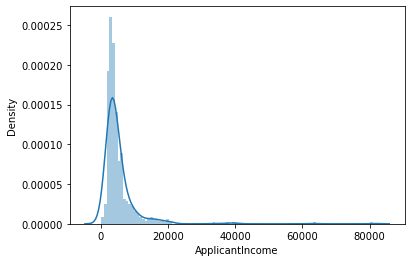

In [31]:
from scipy import stats
from scipy.stats import norm, skew 
sns.distplot(df['ApplicantIncome'],bins=100)

In [32]:
print(df['ApplicantIncome'].mean(),df['ApplicantIncome'].std())

5292.252508361204 5807.265363876918


Esta variable está altamente centrada hacia su media y prensenta una gran dispersión, con una desviación típica de 5807.26, mientras que su media es de 5292.25

### CoapplicantIncome  

<AxesSubplot:xlabel='CoapplicantIncome', ylabel='Density'>

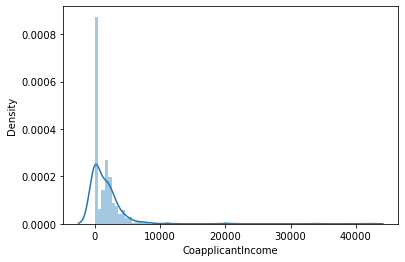

In [33]:
sns.distplot(df['CoapplicantIncome'],bins=80)

In [34]:
print(df['CoapplicantIncome'].mean(),df['CoapplicantIncome'].std())

1631.4998662017392 2953.315784678732


En este caso, la distribución es aún más dispersa debido a que una parte de los individuos no tienen un cosolicitante, por lo que el ingreso del cosolicitante se registra como 0.

### LoanAmount  

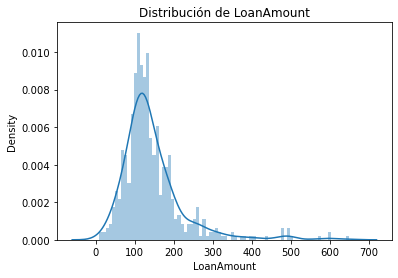

In [35]:
sns.distplot(df['LoanAmount'],bins=80)

plt.title('Distribución de LoanAmount')
plt.show()

Para la variable *LoanAmount*, vamos a reemplazar los valores perdidos por la mediana, con el fin de reducir el sesgo en los datos.

In [36]:
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())

El coeficiente de asimetría para la variable es de 2.59, lo que indica una ligera asimetría positiva, es decir, la media es mayor que la moda. En cuanto a la curtosis, se observa un pico más alto que en una distribución normal, es decir, la variable es leptocúrtica. De hecho, el coeficiente de curtosis es mayor que 3.

In [37]:
print("Asimetría: %f" % df['LoanAmount'].skew())
print("Curtosis: %f" % df['LoanAmount'].kurt())

Asimetría: 2.594077
Curtosis: 9.804411


El test de Shapiro-Wilk considera como hipótesis nula que los datos del *LoanAmount* se distribuyen como una normal. En este caso, el p-valor obtenido es significativamente menor a 0.05, prácticamente 0, por lo tanto, hay suficiente evidencia para rechazar la normalidad.

In [38]:
shapiro_test = stats.shapiro(df['LoanAmount'])
shapiro_test

ShapiroResult(statistic=0.7758428454399109, pvalue=8.363703228681395e-28)

### Loan_Amount_Term  

<AxesSubplot:xlabel='Loan_Amount_Term', ylabel='count'>

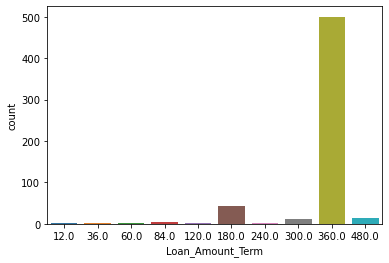

In [39]:
sns.countplot(df['Loan_Amount_Term'])

Para la variable *Loan_Amount_Term*, vamos a reemplazar los valores missing por su moda, ya que se observa claramente en la gráfica que la moda tiene una frecuencia más alta que los demás valores.

In [40]:
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])

### Credit_History       

In [41]:
df['Credit_History'].value_counts()

1.0    463
0.0     86
Name: Credit_History, dtype: int64

In [42]:
df[df['Credit_History']==0]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
7,Male,Yes,3,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
17,Female,No,0,Graduate,No,3510,0.0,76.0,360.0,0.0,Urban,N
20,Male,Yes,0,Not Graduate,No,7660,0.0,104.0,360.0,0.0,Urban,N
22,Male,Yes,0,Not Graduate,No,2600,1911.0,116.0,360.0,0.0,Semiurban,N
36,Male,Yes,0,Graduate,No,1828,1330.0,100.0,360.0,0.0,Urban,N
...,...,...,...,...,...,...,...,...,...,...,...,...
571,Male,Yes,0,Graduate,No,5116,1451.0,165.0,360.0,0.0,Urban,N
584,Male,Yes,1,Graduate,No,2787,1917.0,146.0,360.0,0.0,Rural,N
589,Male,Yes,2,Graduate,Yes,2726,0.0,106.0,360.0,0.0,Semiurban,N
597,Male,No,0,Graduate,No,2987,0.0,88.0,360.0,0.0,Semiurban,N


Si el historial crediticio del solicitante es nulo, significa que no tiene historial crediticio previo. En este caso, reemplazaremos este valor por 1, asumiendo que este es posiblemente el primer préstamo que solicita y que ha cumplido con las pautas y reglas crediticias establecidas.

In [43]:
df['Credit_History'] = df['Credit_History'].fillna(1)

In [44]:
df['Credit_History'].value_counts()

1.0    512
0.0     86
Name: Credit_History, dtype: int64

In [45]:
pd.crosstab(df['Credit_History'], df['Education'])

Education,Graduate,Not Graduate
Credit_History,,
0.0,61,25
1.0,404,108


In [46]:
X2 = stats.chi2_contingency(pd.crosstab(df['Credit_History'], df['Education']), correction=False)[0]
n = np.sum(pd.crosstab(df['Credit_History'], df['Education']))
minDim = min(pd.crosstab(df['Credit_History'], df['Education']).shape)-1
V = np.sqrt((X2/n) / minDim)
print(V)

Education
Graduate        0.076321
Not Graduate    0.142706
dtype: float64


### Property_Area          

In [47]:
df['Property_Area'].value_counts()

Semiurban    225
Urban        198
Rural        175
Name: Property_Area, dtype: int64

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

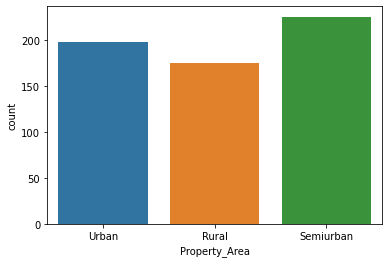

In [48]:
sns.countplot(df['Property_Area'])

### Loan_Status - Variable Objetivo

In [49]:
df['Loan_Status'].value_counts()

Y    411
N    187
Name: Loan_Status, dtype: int64

In [50]:
print('Número de valores missing que nos queda:', df.isnull().sum().sum())

Número de valores missing que nos queda: 0


En la siguiente gráfica se muestra cómo se distribuyen los pares de variables numéricas. Las observaciones en color azul corresponden a préstamos aprobados, mientras que las observaciones en color naranja corresponden a préstamos rechazadaos.

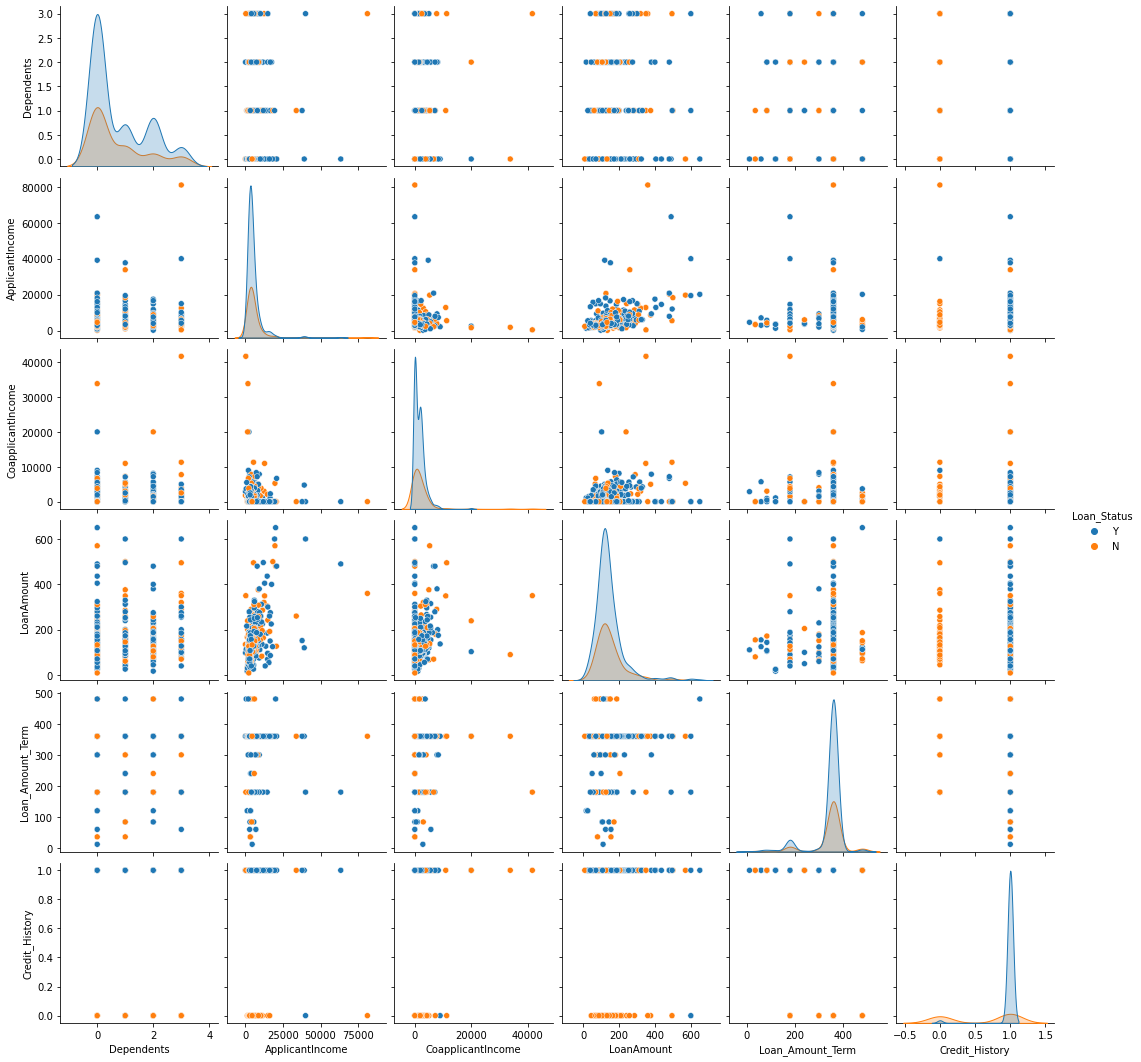

In [51]:
sns.pairplot(data=df,hue='Loan_Status')
plt.show()

Por ejemplo, para todas las gráficas de la última fila o de la última columna, se aprecia claramente que cuando los clientes tienen un historial crediticio positivo, suelen tener una mayor probabilidad de obtener la aprobación del préstamo hipotecario (color azul). 

En las demás gráficas no se aprecia muy bien el comportamiento de *Loan_Status* con las otras variables, ya que parecen estar muy dispersos.

En la gráfica que relaciona las variables *CoapplicantIncome* y *ApplicantIncome*, se puede observar que hay tres préstamos que no han sido aprobados (color naranja), a pesar de que el ingreso del solicitante es signifivativamente más bajo (prácticamente 0) que el ingreso del cosolicitante (mayor que 20000 unidades monetarias).

## Valores outliers

Se ha definido una función llamado *IQR_method* en el archivo *f_auxiliares.py*, que hemos importado como *f_aux* en la primera celda del notebook. Los parámetros de entrada de esta función son el *dataframe* a analizar, el número mínimo de veces que una observación debe ser considerada outlier *n*, y las *columnas* del dataframe que se desean analizar. La función devuelve el índice de aquellas observaciones que han sido consideradas outlier más de *n* veces en las columnas especificadas.

In [52]:
Outliers_IQR = f_aux.IQR_method(df,2,['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'])

Outliers_IQR

Total number of outliers is: 86


[9, 54, 128, 130, 155, 333, 409, 506, 177, 253, 372, 600]

In [53]:
df = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

## Correlación

A pesar de que tenemos numerosas variables de tipo *object*, es posible estudiar la correlación de Pearson entre las variables tipo numéricas.

<AxesSubplot:>

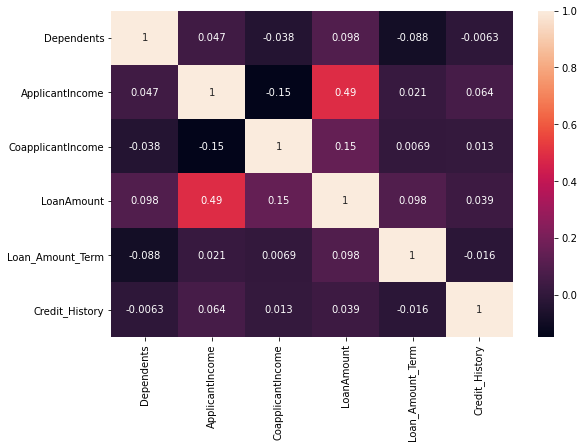

In [54]:
corrmat = df.corr()
plt.subplots(figsize=(9,6))
sns.heatmap(corrmat, annot=True)

## Variables dummies


En R, para usar variables categóricas se utilizan los llamados *factor*, y los modelos se entrenan sin problemas. Pero en el caso de Python, es necesario convertir estas variables mediante algún tipo de *encoding* para poder trabajarlas con modelos de machine learning.

Los dos encoding más utilzados son: 
- **Label encoding**: al codificarlos, se establece un orden (por defecto se establece el orden alfabético). Un ejemplo sería el caso de codificar 'Infantil', 'Primaria', 'Secundaria', 'Universidad'.
- **One Hot encoding / pd.getdummies**: si se tienen *n* valores, se crean *n-1* columnas binarias que indican si ese valor pertenece o no a la observación correspondiente.

En nuestros datos, no tenemos ninguna variable cualitativa en la que se pueda establecer algún tipo de orden, por lo que se codificarán todas mediante una variables dummy.

In [55]:
df = pd.get_dummies(df, columns=['Gender', 'Married', 'Education', 'Self_Employed','Property_Area','Loan_Status'], drop_first=True)

In [56]:
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,0,5849,0.0,127.0,360.0,1.0,1,0,0,0,0,1,1
1,1,4583,1508.0,128.0,360.0,1.0,1,1,0,0,0,0,0
2,0,3000,0.0,66.0,360.0,1.0,1,1,0,1,0,1,1
3,0,2583,2358.0,120.0,360.0,1.0,1,1,1,0,0,1,1
4,0,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,1,1


Por ejemplo, si el valor *Gender_Male* es 1 significa que es hombre y si es 0 significa que es mujer.

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Dependents               586 non-null    int64  
 1   ApplicantIncome          586 non-null    int64  
 2   CoapplicantIncome        586 non-null    float64
 3   LoanAmount               586 non-null    float64
 4   Loan_Amount_Term         586 non-null    float64
 5   Credit_History           586 non-null    float64
 6   Gender_Male              586 non-null    uint8  
 7   Married_Yes              586 non-null    uint8  
 8   Education_Not Graduate   586 non-null    uint8  
 9   Self_Employed_Yes        586 non-null    uint8  
 10  Property_Area_Semiurban  586 non-null    uint8  
 11  Property_Area_Urban      586 non-null    uint8  
 12  Loan_Status_Y            586 non-null    uint8  
dtypes: float64(4), int64(2), uint8(7)
memory usage: 31.6 KB


## Balanceo de datos

En la clasificación, es importante identificar si hay desbalanceo de datos, ya que esto puede llevar a que se dé un mayor peso a la clase mayoritaria y se obtengan predicciones menos precisas.

<AxesSubplot:>

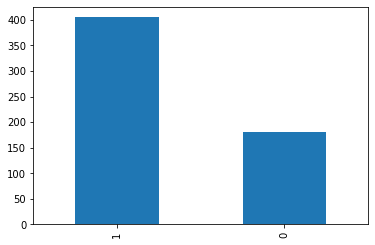

In [58]:
df['Loan_Status_Y'].value_counts().plot.bar()

In [59]:
df.shape

(586, 13)

Observamos que sí hay un desbalanceo en los datos. Existen dos formas de abordar este problema: undersampling y oversampling. El undersampling reduce la diferencia en el balanceo eliminando aleatoriamente datos de la clase mayoritaria, mientras que el oversampling genera datos sintéticos nuevos añadiendo valores a la clase minoritaria. 

Como nuestro conjunto de datos no es muy grande, es preferible aplicar oversampling en lugar de undersampling para no perder más información.

In [60]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 0)
ros.fit_resample(df.drop('Loan_Status_Y', axis = 1), df[['Loan_Status_Y']])
print('Filas que nos quedamos:', len(ros.sample_indices_))

Filas que nos quedamos: 810


<AxesSubplot:>

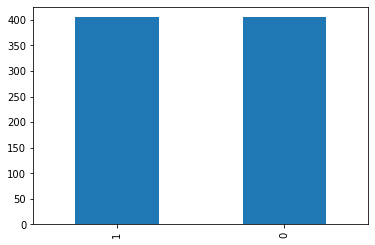

In [61]:
df_balanced = df.iloc[ros.sample_indices_]
df_balanced['Loan_Status_Y'].value_counts().plot.bar()

In [62]:
df_balanced.shape

(810, 13)

## Datos de Training y Test

Vamos a hacer dos particiones de datos, uno para los datos originales y el otro para los datos balanceados. Se ha elegido un 80% de los datos como datos de entrenamiento y 20% como de test.

In [63]:
y = df['Loan_Status_Y']
X = df.drop('Loan_Status_Y',axis=1)

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [65]:
print(X_train.shape)
print(X_test.shape)

(468, 12)
(118, 12)


In [66]:
y_balanced = df_balanced['Loan_Status_Y']
X_balanced = df_balanced.drop('Loan_Status_Y',axis=1)

In [67]:
from sklearn.model_selection import train_test_split
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size = 0.2, random_state = 0)

In [68]:
print(X_train_balanced.shape)
print(X_test_balanced.shape)

(648, 12)
(162, 12)


# Problema de clasificación

La variable a clasificar es *Loan_Status*. Vamos a entrenar con un modelo de la caja negra, Random Forest, utilizando tanto los datos originales como los datos balanceados. Y seleccionaremos el modelo con el mejor rendimiento en términos de métricas de evaluación.

## Entrenamiento de los datos mediante Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators = 250, random_state = 123)

rfc_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, random_state=123)

In [70]:
y_pred = rfc_model.predict(X_test)

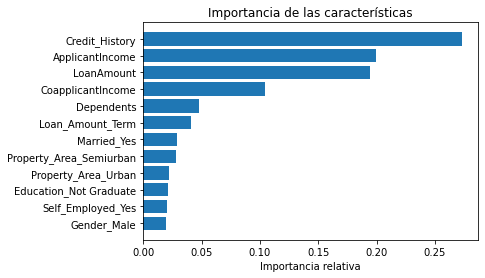

In [71]:
importances = rfc_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Importancia de las características')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importancia relativa')
plt.show()

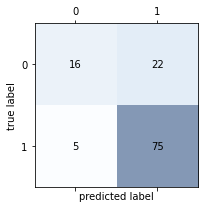

ACC:  0.7711864406779662
SEN:  0.9375
ESP:  0.42105263157894735
PPV:  0.7731958762886598
FSC:  0.847457627118644


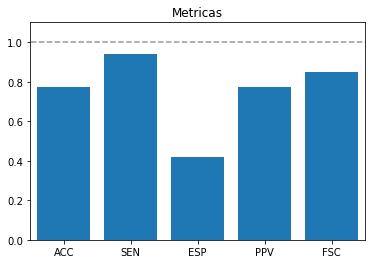

In [72]:
from sklearn.metrics import confusion_matrix
confmat_test = confusion_matrix(y_test, y_pred)
f_aux.plot_confusion_matrix(confmat_test)
f_aux.calcula_metricas(confmat_test)

La matriz de confusión anterior indica que tenemos 67 verdaderos positivos, 22 falsos positivos, 18 verdaderos negativos y 10 falsos negativos.

Las métricas son respectivamente:
- Accuracy (ACC), indica el porcentaje total de elementos clasificados correctamente.
- Sensibilidad (SEN), indica el porcentaje de elementos identificados correctamente como positivos del total de verdaderos positivos.
- Especificidad (ESP), lo mismo que la sensibilidad, solo que para verdaderos negativos.
- Recall (PPV), indica el porcentaje de elementos identificados correctamente como positivo de un total de elementos identificados como positivos.
- F1-Score (FSC), es une medida que combina las métricas anteriores en una sola.

En este caso nos ha dado una especificidad baja (0.45), es decir, de todos los que ha predicho como negativos, solo el 45% están bien clasificados. Vamos a ver si con los datos balanceados se obtiene un mejor resultado, ya que esto es posiblemente debido a que tenemos más *Yes* en la variable a clasificar *Loan_Status*.

## Entrenamiento mediante Random Forest con datos balanceados

In [73]:
rfc_model = RandomForestClassifier(n_estimators = 250, random_state = 123)

rfc_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(n_estimators=250, random_state=123)

In [74]:
y_pred_balanced = rfc_model.predict(X_test_balanced)

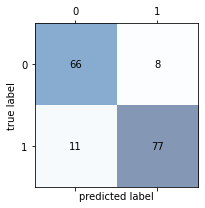

ACC:  0.8827160493827161
SEN:  0.875
ESP:  0.8918918918918919
PPV:  0.9058823529411765
FSC:  0.8901734104046243


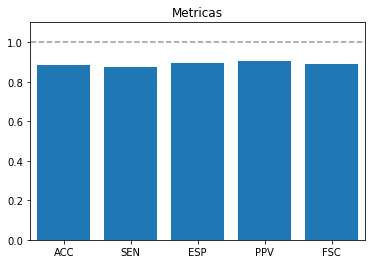

In [75]:
confmat_test = confusion_matrix(y_test_balanced, y_pred_balanced)
f_aux.plot_confusion_matrix(confmat_test)
f_aux.calcula_metricas(confmat_test)

Efectivamente, resulta que se tiene mejores medidas con los datos balanceados. En el siguiente apartado de Interpretabilidad, vamos a trabajar solamente con los datos balanceados.

## Interpretabilidad

Primero hay que importar la librería *shap* que usaremos en este apartado. Descargarlo en caso necesario.

In [76]:
# pip install shap

In [77]:
import shap

In [78]:
row_to_show = 12
data_for_prediction = X_test_balanced.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

data_for_prediction

Dependents                    2.0
ApplicantIncome            4006.0
CoapplicantIncome          1526.0
LoanAmount                  168.0
Loan_Amount_Term            360.0
Credit_History                1.0
Gender_Male                   1.0
Married_Yes                   1.0
Education_Not Graduate        0.0
Self_Employed_Yes             0.0
Property_Area_Semiurban       0.0
Property_Area_Urban           1.0
Name: 8, dtype: float64

In [79]:
row_to_show = 10
data_for_prediction_new = X_test_balanced.iloc[row_to_show]  
data_for_prediction_array_new = data_for_prediction_new.values.reshape(1, -1)

data_for_prediction_new

Dependents                    0.0
ApplicantIncome            5500.0
CoapplicantIncome             0.0
LoanAmount                  105.0
Loan_Amount_Term            360.0
Credit_History                0.0
Gender_Male                   0.0
Married_Yes                   1.0
Education_Not Graduate        0.0
Self_Employed_Yes             1.0
Property_Area_Semiurban       0.0
Property_Area_Urban           0.0
Name: 337, dtype: float64

In [80]:
print(rfc_model.predict_proba(data_for_prediction_array))
print(rfc_model.predict_proba(data_for_prediction_array_new))

[[0.344 0.656]]
[[0.96 0.04]]


Como este trabajo consiste en un análisis local, se ha elegido la observación de la fila 10 y 12 de los datos de test para analizar. 

Para la fila 12, se tiene un 65.6% de probabilidad de que se le acepte la petición del préstamo hipotecario, y un 34.4% de que lo rechace. Es decir, se va a clasificar como *Loan_Status_Y = 1*, sí van a aceptar la petición. Y para la fila 10, solamente tiene un 4% de probabilidad de que se le acepte la petición, por tanto, se va a clasificar como *Loan_Status_Y = 0*.

A continuación, veamos cuáles son los factores más han contribuido a estas predicciones mediante distintos métodos comentados en la memoria.

### Shapley value: shap.explainers.Sampling

El primer método es SamplingExplainer. Este método calcula el valor de Shapley asumiendo que las características son independientes, usando la formulación marginal. Es una extensión del algoritmo ApproShapley propuesto por Erik Strumbelj e Igor Kononenko en 2010.

In [81]:
sampling_explainer = shap.SamplingExplainer(rfc_model.predict_proba,data=X_train_balanced)

In [82]:
%%time
sampling_values = sampling_explainer.shap_values(data_for_prediction)

Wall time: 1.74 s


In [83]:
%%time
sampling_values_new = sampling_explainer.shap_values(data_for_prediction_new)

Wall time: 1.66 s


In [84]:
sampling_values

[array([-0.02821899,  0.00710835, -0.05080051,  0.02791779, -0.01235287,
        -0.11684992, -0.0146102 , -0.00209555, -0.01743935,  0.00080269,
         0.03434551, -0.01293039]),
 array([ 0.02821899, -0.00710835,  0.05080051, -0.02791779,  0.01235287,
         0.11684992,  0.0146102 ,  0.00209555,  0.01743935, -0.00080269,
        -0.03434551,  0.01293039])]

Nos devuelve dos arrays porque se trata de una clasificación. El primero contiene las atribuciones del valor de Shapley para la clase 0 (rechazo del préstamo) y el segundo contiene las atribuciones para la clase 1 (aceptación del préstamo). A continuación, nos enfocaremos en *sampling_values[1]*, que son los valores asociados a la clase de aceptación del préstamo.

In [85]:
suma_vs = sampling_values[1].sum()
base_value = sampling_explainer.expected_value[1]
pred = rfc_model.predict_proba(data_for_prediction_array)[:,1]
suma_vs == (pred[0] - base_value)

False

In [86]:
suma_vs

0.18512345752309547

In [87]:
pred[0] - base_value

0.18512345679012376

Observamos que la suma del valor de Shapley de todas las características (0.185) para la observación 12 tiene el mismo valor que la resta de la predicción de la observación (0.66) dada menos el *base_value*(0.4709), de forma que cumple la propiedad de eficiencia.

In [88]:
shap.initjs()
shap.force_plot(sampling_explainer.expected_value[1], sampling_values[1], data_for_prediction)

En esta gráfica nos muestra que el promedio de todas las probabilidades predichas por el modelo es 0.4709, mientras que la predicción para la fila 12 es de 66%. Las variables que afectan positivamente a la probabilidad de la predicción están representadas por el color rojo, mientras que las variables que hacen decrecer la probabilidad están de color azul. 

En este caso, el ingreso del cosolicitante, que es de 1526 unidades monetarias, hace que sea más probable que se acepte la solicitud del préstamo hipotecario.

In [89]:
shap.initjs()
shap.force_plot(sampling_explainer.expected_value[1], sampling_values_new[1], data_for_prediction_new)

En el caso de la observación 10, el factor más relevante que ha llevado a la denegación del préstamo es que en su historial crediticio no se cumplieron con las pautas establecidas.

### SHAP

De forma análoga, construimos el mismo procedimiento, pero ahora usando el método SHAP. La clase que se va a usar es *shap.KernelSHAP* puesto que SHAP usa la estimación KernelSHAP para los valores de Shapley.

In [90]:
explainer = shap.KernelExplainer(rfc_model.predict_proba,data=X_train_balanced)

Using 648 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


En SHAP nos avisa de que el conjunto de datos con 162 observaciones puede tardar mucho, y nos aconseja utilizar una muestra más pequeña. Usando shap.sample por defecto, se tomará una muestra de 100 observaciones.

In [91]:
%%time
shap_values = explainer.shap_values(data_for_prediction)

Wall time: 33 s


El tiempo de cómputo de SHAP es el más lento con 33 segundos en ejecución. Y esto es el motivo por el cual no es un método muy usado en la vida real.

In [92]:
shap_values

[array([-0.0322811 ,  0.00878718, -0.04821413,  0.02621387, -0.01139215,
        -0.1121102 , -0.01541744,  0.00109577, -0.01574583, -0.00089004,
         0.03033348, -0.01550287]),
 array([ 0.0322811 , -0.00878718,  0.04821413, -0.02621387,  0.01139215,
         0.1121102 ,  0.01541744, -0.00109577,  0.01574583,  0.00089004,
        -0.03033348,  0.01550287])]

In [93]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Observamos que obtenemos una gráfica similar a la anterior, pero los valores numéricos son distintos.

### TreeSHAP

Probamos ahora con el TreeSHAP.

In [94]:
tree_explainer = shap.TreeExplainer(rfc_model,data=X_train_balanced)

In [95]:
%%time
tree_shap_values = tree_explainer.shap_values(data_for_prediction)

Wall time: 77.9 ms


In [96]:
tree_shap_values

[array([-0.03243815,  0.01562491, -0.03620429,  0.02804729, -0.01182833,
        -0.12761961, -0.01379824,  0.00166386, -0.023274  ,  0.00224865,
         0.03395619, -0.02189829]),
 array([ 0.03243814, -0.0156249 ,  0.03620429, -0.02804729,  0.01182833,
         0.12761961,  0.01379824, -0.00166386,  0.023274  , -0.00224865,
        -0.03395619,  0.02189829])]

In [97]:
shap.initjs()
shap.force_plot(tree_explainer.expected_value[1], tree_shap_values[1], data_for_prediction)

Gracias a que el método de TreeSHAP es muy rápido en calcular el valor de Shapley, es posible estimar los valores de Shapley para la explicación de todas las observaciones y representarlos conjuntamente. 

In [98]:
tree_explainer = shap.TreeExplainer(rfc_model)
shap_all_values = tree_explainer.shap_values(X_train_balanced)

In [99]:
shap_all_values[1].shape

(648, 12)

En este caso, shap_all_values es una matriz de valores de Shapley, con 646 filas (observaciones) y 12 columnas(características), donde cada posición indica el valor de Shapley para cada observación y cada característica. Las cifras con valores negativos indican que tienden a disminuir la probabilidad de la aprobación del préstamo, y los valores positivos tienden a aumentar la probabilidad con respecto a la predicción media. 

In [100]:
shap_all_values[1]

array([[ 0.00678891,  0.0394489 ,  0.0131394 , ..., -0.0002287 ,
        -0.05572742,  0.00781387],
       [ 0.00724839,  0.0711032 ,  0.03305668, ...,  0.01452878,
         0.08005622,  0.00492643],
       [ 0.01812224, -0.01436871,  0.00309869, ...,  0.0066104 ,
         0.14397539,  0.00498498],
       ...,
       [-0.06859122, -0.17706927, -0.03845912, ..., -0.06614855,
        -0.08381904, -0.02977609],
       [-0.0197453 ,  0.01619638,  0.01640588, ...,  0.00200851,
        -0.03022039, -0.00282713],
       [-0.06637399, -0.15769326, -0.05728107, ..., -0.00217114,
        -0.10889119, -0.04573039]])

In [101]:
shap.initjs()
shap.force_plot(tree_explainer.expected_value[1], shap_all_values[1], X_train_balanced)

Juntando todas las observaciones, tenemos esta gráfica. Muestra la agrupación de todas las gráficas individuales (como la mostrada anteriormente) colocadas verticalmente. A veces, se usa esta gráfica para hacer clustering, ordenando las observaciones por similitud. Por ejemplo, para este conjunto de datos se pueden separar en tres subgrupos, dependiendo de cómo atribuyen las características.

#### Summary plot

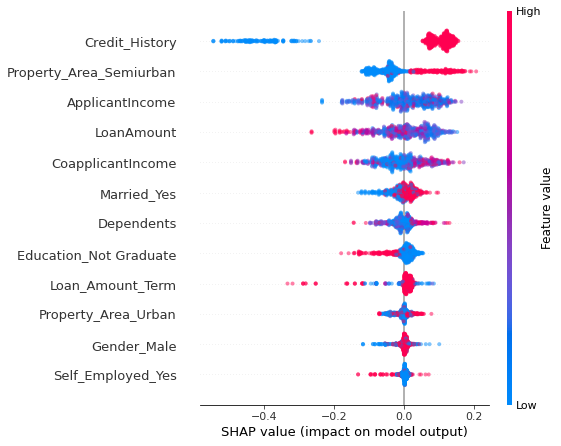

In [102]:
shap.summary_plot(shap_all_values[1], X_train_balanced,alpha=0.5)

El summaryplot combina la importancia de las características con el efecto de cada característica. Para el eje horizontal, cada punto es el valor de Shapley para una observación y las características del eje vertical están ordenados de arriba hacia abajo según la importancia de la característica. El color indica el valor de la característica, cuanto más rojo sea, mayor valor tiene, y cuanto más azul sea, menor valor tiene.

De hecho, esto sería una interpretación global, puesto que refleja cómo influye cada característica en la predicción de una forma genérica. En este caso, el historial crediticio es el factor que más decide si aprobar o no la petición del préstamo. Si el solicitante ha tenido algún incumplimiento en su historial crediticio, el banco tiende a rechazar la petición del préstamo. El segundo factor que destaca es si la propiedad pertenece a una zona semi urbana, ya que cuando lo es, tiene siempre mayor posibilidad de ser aprobada la petición. 

Por otro lado, también se aprecia de forma clara el efecto de la educación y el estado civil, aunque tienen menos importancia a nivel global. Si el solicitante está casado, aumenta la probabilidad de que su solicitud sea aprobada. En cuanto al nivel de estudio, si el solicitante es licenciado no tiene un gran impacto en la probabilidad de ser aprobada, pero si no está licenciado, influye significativamente en la probabilidad de que sea rechazada.

Para  factores como el ingreso del solicitante y cosolicitante, así como el monto del préstamo no se aprecia muy bien su impacto a nivel global. Por lo tanto, se puede recurrir a la gráfica de dependencia para ver cómo se comportan.

#### Summary plot

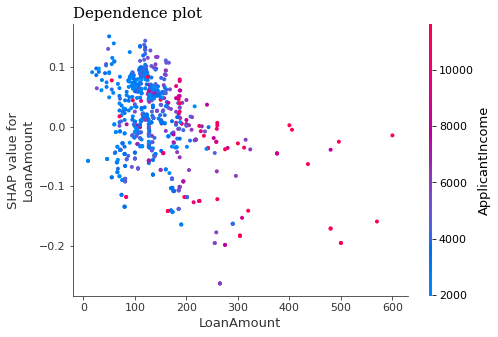

In [103]:
shap.dependence_plot('LoanAmount', shap_all_values[1], X_train_balanced, interaction_index="ApplicantIncome",show=False)
plt.title("Dependence plot",loc='left',fontfamily='serif',fontsize=15)
plt.show()

En la gráfica de dependencia, cada punto representa una observación y en el eje horizontal se encuentra el valor de la característica en cuestión, mientras que en el eje vertical se encuentra el valor de Shapley asociado a esa característica. El color indica el valor de la otra característica y se utiliza para identificar si hay alguna relación entre ellas.

En esta gráfica, se puede observar que a medida que el monto del préstamo aumenta, disminuye la probabilidad de que el préstamo sea aprobado, incluso si el solicitante tiene un ingreso extremadamente alto (los puntos situados a la derecha tienen un valor de Shapley negativo). 

## Comparación de los diferentes métodos

Ya hemos visto que el tiempo que tarda cada método es diferente con tan solo aproximadamente 600 observaciones. Esta diferencia de tiempo se apreciará mejor si se tiene un conjunto de datos más grande. En resumen, SHAP es el más lento y no es muy práctico en la vida real. Sampling es un poco más eficiente que SHAP, y en general solo se usa a nivel local ya que no es tan eficaz como TreeSHAP. El método más usados hoy en día es TreeSHAP. 

Veamos ahora las diferencias entre los valores de Shapley calculados por distintos métodos.

In [104]:
print(sampling_values[1])
print(tree_shap_values[1])
print(shap_values[1])

[ 0.02821899 -0.00710835  0.05080051 -0.02791779  0.01235287  0.11684992
  0.0146102   0.00209555  0.01743935 -0.00080269 -0.03434551  0.01293039]
[ 0.03243814 -0.0156249   0.03620429 -0.02804729  0.01182833  0.12761961
  0.01379824 -0.00166386  0.023274   -0.00224865 -0.03395619  0.02189829]
[ 0.0322811  -0.00878718  0.04821413 -0.02621387  0.01139215  0.1121102
  0.01541744 -0.00109577  0.01574583  0.00089004 -0.03033348  0.01550287]


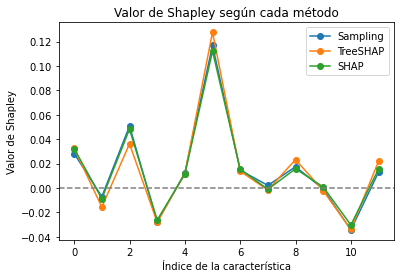

In [105]:
x = np.array(range(0,12))

fig, ax = plt.subplots()

ax.plot(x, sampling_values[1],  label='Sampling',marker = "o")
ax.plot(x, tree_shap_values[1], label='TreeSHAP',marker = "o")
ax.plot(x, shap_values[1], label='SHAP',marker = "o")
ax.axhline(y=0, color='gray', linestyle='--')

ax.set_xlabel('Índice de la característica')
ax.set_ylabel('Valor de Shapley')
ax.set_title('Valor de Shapley según cada método')
ax.legend()

plt.show()

A pesar de las ligeras diferencias, observamos que los resultados obtenidos por los tres métodos siguen el mismo patrón.

In [106]:
dif_shap_samp=abs(shap_values[1]-sampling_values[1])
dif_shap_tree=abs(shap_values[1]-tree_shap_values[1])
dif_tree_samp=abs(tree_shap_values[1]-sampling_values[1])

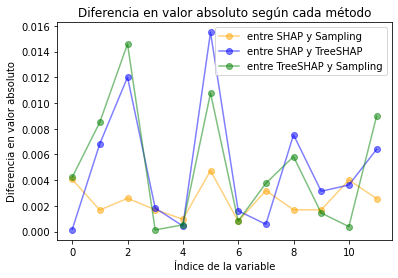

In [107]:
plt.title("Diferencia en valor absoluto según cada método")
plt.xlabel("Índice de la variable")
plt.ylabel("Diferencia en valor absoluto")

plt.plot(np.array(range(0,12)), dif_shap_samp, color = "orange",  alpha = 0.5, marker = "o", label = "entre SHAP y Sampling")
plt.plot(np.array(range(0,12)), dif_shap_tree, color = "blue",  alpha = 0.5, marker = "o", label = "entre SHAP y TreeSHAP")
plt.plot(np.array(range(0,12)), dif_tree_samp, color = "green",  alpha = 0.5, marker = "o", label = "entre TreeSHAP y Sampling")

plt.legend()
plt.show()

Esta gráfica muestra la diferencia en valor absoluto entre los distintos métodos. La diferencia es mínima (la máxima diferencia es de 0.016 entre SHAP y TreeSHAP para la 2º característica), por lo que podríamos decir que los resultados obtenidos por los cuatro métodos son igual de creíbles. Si tenemos un conjunto grande de datos con más características, es probable que los valores de Shapley estimados no sean tan similares y la diferencia entre los métodos sea mayor.

Para complementar el trabajo, sería interesante llevar a cabo un estudio computacional con más casos. Esto permitiría no sólo para ilustrar cómo se pueden usar estos métodos y ver el comportamiento de los valores de Shapley de los diferentes individuos, sino para estudiar el efecto que podría tener trabajar con características altamente correlacionadas sobre el enfoque condicional y marginal, analizando las diferencias entre los valores proporcionados y cómo se ven afectados por las interacciones entre características (el efecto sobre la respuesta de una de ellas dependa del valor que tome otra).